### Data Augmentation 데이터 확장

- 한장의 사진을 여러 각도, 여러 색깔, 다르게 edit해서 컴퓨터 비전의 성능을 향상시키는 방법

- 보통 Training단계에서 많이 쓰이지만, 상황에 따라 Test 단계에서도 사용이 가능, 이를 Test Time Augmentation(TTA)라고 함.
    - 한장의 Test Image를 여러장으로 증강시켜 Interence를 시킨 뒤, 나온 output을 ensemble하는 방식이며,

    - kaggle과 같은 챌린지에서 많이 사용됨

- 간단히 말해 Do more with Less Data

### Albumentation

- numpy, opencv 기반으로 구현된 image transform library이며,

- 사용법은 torchivision.transform과 비슷함, 다만

- torchvision보다 약 2~15배 빠른 속도를 나타냄!! 

In [2]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
from albumentations.pytorch import ToTensorV2

In [3]:
# 기존 torchvision Data pipeline
# 1. dataset class --> image loader --> transforms
class CatDataset(Dataset): # basic of custom dataset
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __getitem__(self, index):
        file_path = self.file_paths[index]

        # 원래라면 image, label을 return 해야함(이미지와 정답지)

        # Read an image with PIL
        image = Image.open(file_path).convert("RGB")

        # transform time check(시간 얼마나 걸리나 재보자)
        start_tiem = time.time() # 시작 시간
        if self.transform:
            image = self.transform(image)
        end_tiem = (time.time() - start_tiem)

        return image, end_tiem

    def __len__(self):
        return len(self.file_paths)

In [4]:
# 신규 albumentations Data pipeline
class alb_cat_dataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __getitem__(self, index):
        file_path = self.file_paths[index]

        # read an image with opencv
        image = cv2.imread(file_path)

        # BGR --> RGB로 변경
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        self.st_time = time.time()
        if self.transform is not None:
            image = self.transform(image=image)["image"]
            total_time = (time.time() - self.st_time)

        return image, total_time

    def __len__(self):
        return len(self.file_paths)

In [5]:
# Data augmentation transforms
# train용을 따로 만들어서 해야함
# train_transform = transforms.Compose([
#     ㅁㅁㅁㅁ
# ])
# val용
# val_transform = transforms.Compose([
#     ㅁㅁㅁㅁ(train과 동일하게 작성. 단, 랜덤 요소 제외. test는 어차피 고정값이라 val용 가져다 쓰면 됨.)
# ])
# 어떤 기능을 하는지 각각 캡처떠서 제출

In [6]:
torchvision_transform = transforms.Compose([
    transforms.Pad(padding=100),
    transforms.Resize((256,256)),
    transforms.CenterCrop(size=(30)), # 사용을 거의 하지 않는다. 학습에 영 도움이 안 되는 crop이 됨. 만약, 이미지 상 다 동일한 위치면 사용해도 됨.
    transforms.Grayscale(), # 특수한 경우에만 사용
    transforms.ColorJitter(brightness=0.5, hue=0.2, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(3,9), sigma=(0.1, 5)),
    transforms.RandomPerspective(distortion_scale=0.7, p=1.0),
    transforms.RandomRotation(degrees=(0,100)),
    transforms.RandomAffine(degrees=(30,60), translate=(0.1, 0.3), scale=(0.5,0.7)),
    # transforms.ElasticTransform(alpha=255.0), # 버전 차이 --> 상위 버전에서 사용 가능
    transforms.RandomEqualize(p=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(), # 자동으로 아무거나 augmentation을 먹여줌. 뭐가 들어갈지 모름;;
    
    # # 비교용 transforms 설정
    # transforms.Resize((256,256)),
    # transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor() # augmentation 처리된 결과(=이미지)를 tensor화 해줘!
])

In [7]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.RandomCrop(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.VerticalFlip(),
    # albumentations.pytorch.transforms.ToTensor(),  --> 이 버전에선 안 됨
    ToTensorV2()
])

In [8]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(256,256),
    albumentations.RandomCrop(224,224),
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=1),
        albumentations.RandomRotate90(p=1),
        albumentations.VerticalFlip(p=1)
    ], p=1),
    albumentations.OneOf([
        albumentations.MotionBlur(p=1),
        albumentations.OpticalDistortion(p=1),
        albumentations.GaussNoise(p=1)
    ], p=1),
    ToTensorV2
])

In [9]:
cat_dataset = CatDataset(file_paths=["cat.png"], transform=torchvision_transform)
alb_dataset = alb_cat_dataset(file_paths=['cat.png'], transform=albumentations_transform)
alb_oneof = alb_cat_dataset(file_paths=["cat.png"], transform=albumentations_transform_oneof)

torchvision tiem/image >>  9.319941997528076
alb time >>  0.7545757293701172


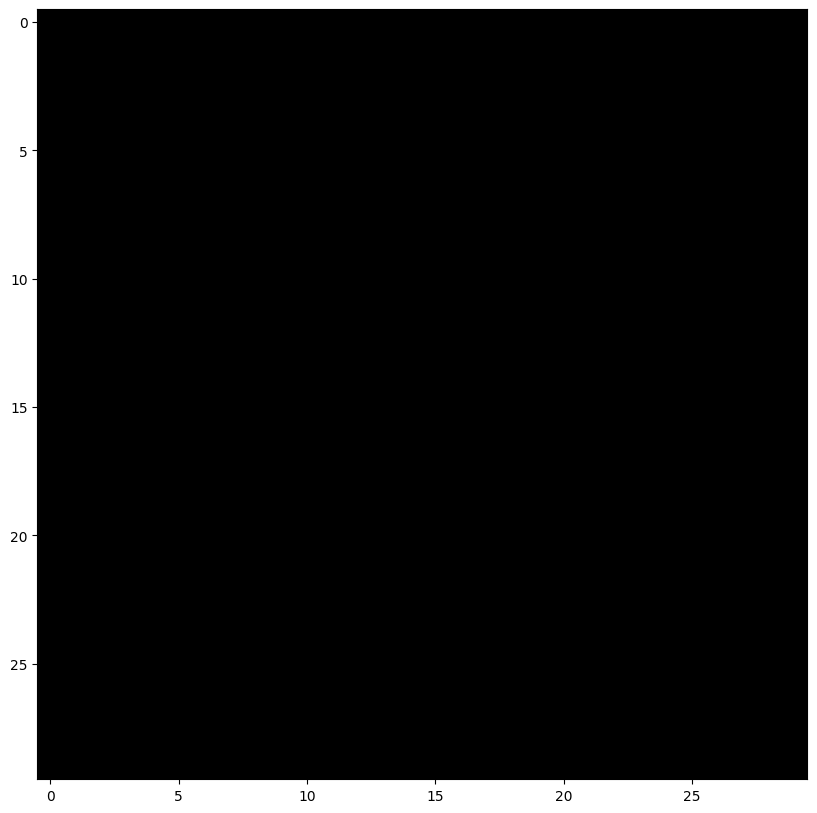

In [10]:
total_time = 0
for i in range(100):
    image, end_ime = cat_dataset[0]
    total_time += end_ime
print("torchvision tiem/image >> ", total_time*10)

alb_total_tiem = 0
for i in range(100):
    alb_image, alb_time = alb_dataset[0]
    alb_total_tiem += alb_time
print("alb time >> ", alb_total_tiem*10)

plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(image).convert("RGB"))
plt.show()